In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [67]:
arimadf = pd.read_csv('/content/Electric_Production.csv')
arimadf['Value'] = arimadf['Value'].astype(float)
arimadf['DATE'] = pd.to_datetime(arimadf['DATE'], infer_datetime_format=True)
arimadfind = arimadf.set_index('DATE')
arimadfind = arimadfind.asfreq('MS')

In [68]:
arimadf.shape

(397, 2)

In [69]:
arimadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [70]:
arimadfind = arimadf.set_index('DATE',inplace=False)

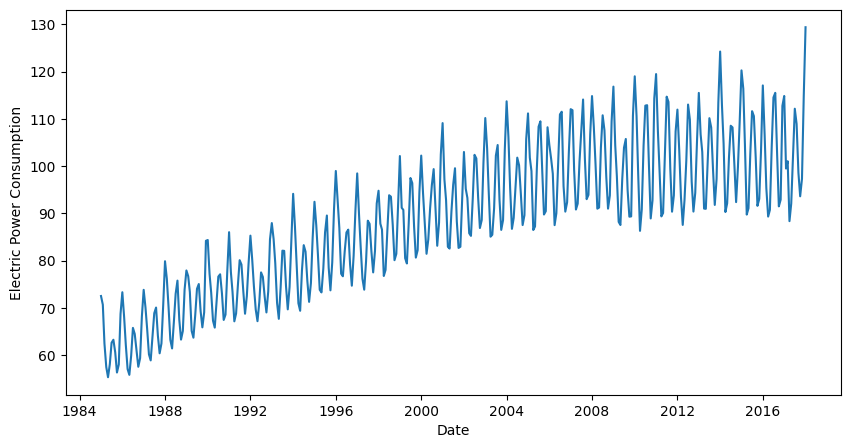

In [71]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(arimadfind)

In [72]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    arimadf_test = adfuller(timeseries['Value'], autolag='AIC')
    dfoutput = pd.Series(arimadf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in arimadf_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

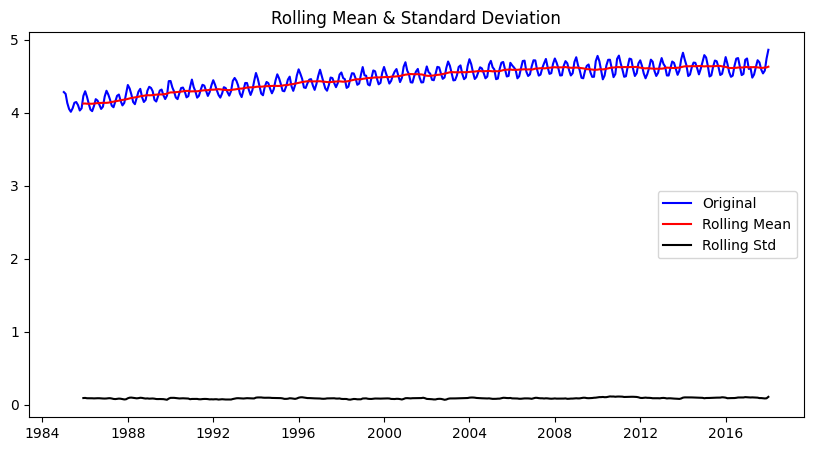

Results of Dickey Fuller Test:
Test Statistic                  -3.145360
p-value                          0.023373
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [73]:
arimadf_log = np.log(arimadfind)
test_stationarity(arimadf_log)

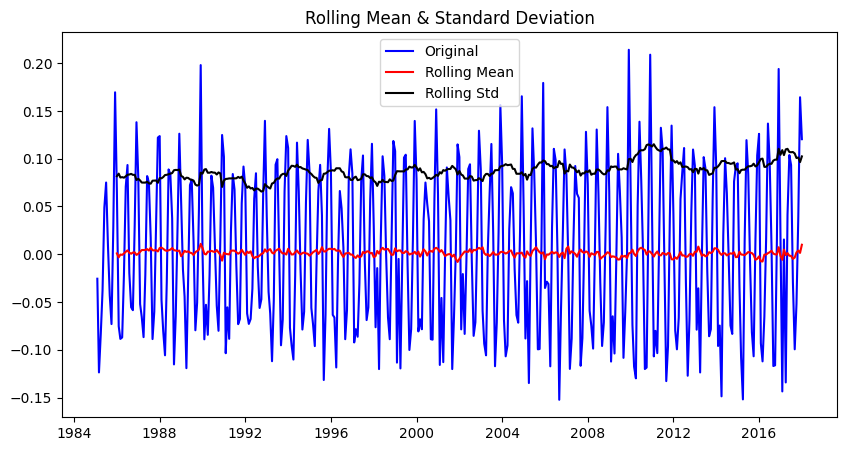

Results of Dickey Fuller Test:
Test Statistic                -6.748333e+00
p-value                        2.995161e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [74]:
arimadf_log_diff = arimadf_log - arimadf_log.shift()
arimadf_log_diff.dropna(inplace=True)
test_stationarity(arimadf_log_diff)

In [75]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [76]:
rollmean_log = arimadf_log.rolling(window=12).mean()
rollstd_log = arimadf_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

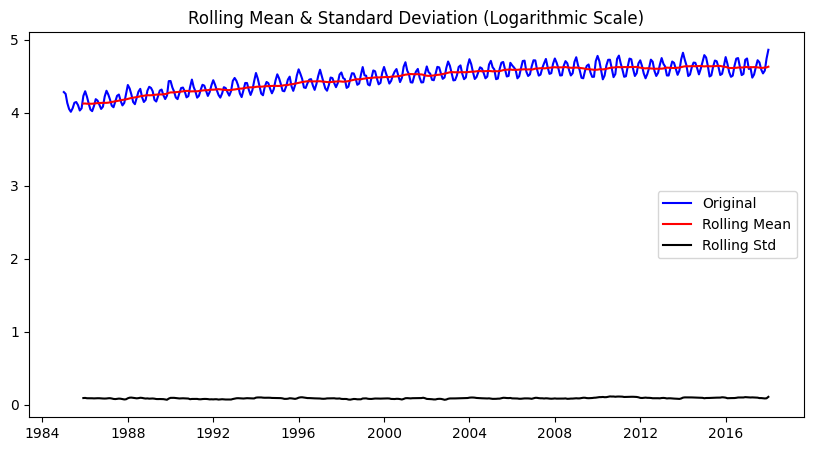

In [77]:
plt.figure(figsize=(10,5))
plt.plot(arimadf_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

In [78]:
arimadf_new = arimadf_log - rollmean_log

In [79]:
arimadf_new.head()

,Value
DATE,
1985-01-01,NaN
1985-02-01,NaN
1985-03-01,NaN
1985-04-01,NaN
1985-05-01,NaN


In [80]:
arimadf_new.dropna(inplace=True)

In [81]:
arimadf_new.head()

,Value
DATE,
1985-12-01,0.103961
1986-01-01,0.167724
1986-02-01,0.095629
1986-03-01,0.007329
1986-04-01,-0.079115


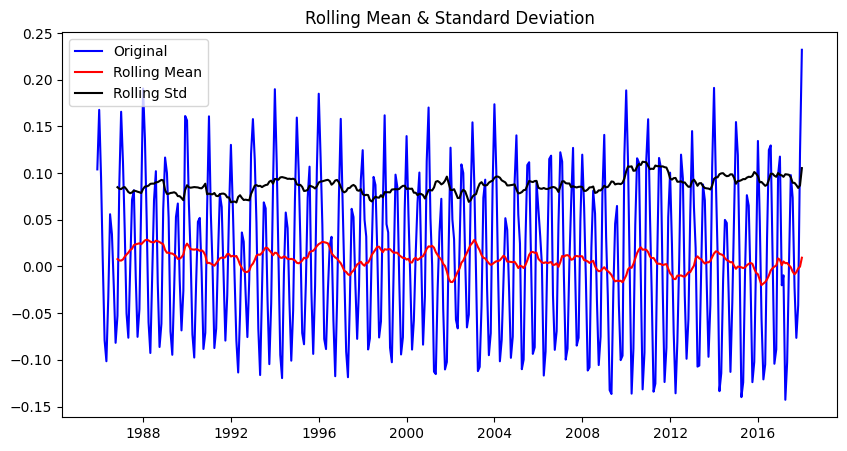

Results of Dickey Fuller Test:
Test Statistic                  -5.211586
p-value                          0.000008
#Lags Used                      15.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


In [82]:
test_stationarity(arimadf_new)

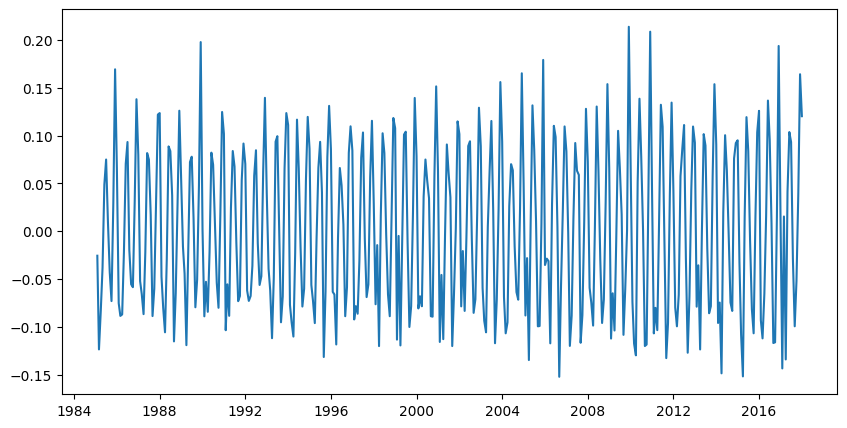

In [83]:
arimadf_log_diff = arimadf_log - arimadf_log.shift()
plt.figure(figsize=(10,5))
plt.plot(arimadf_log_diff)

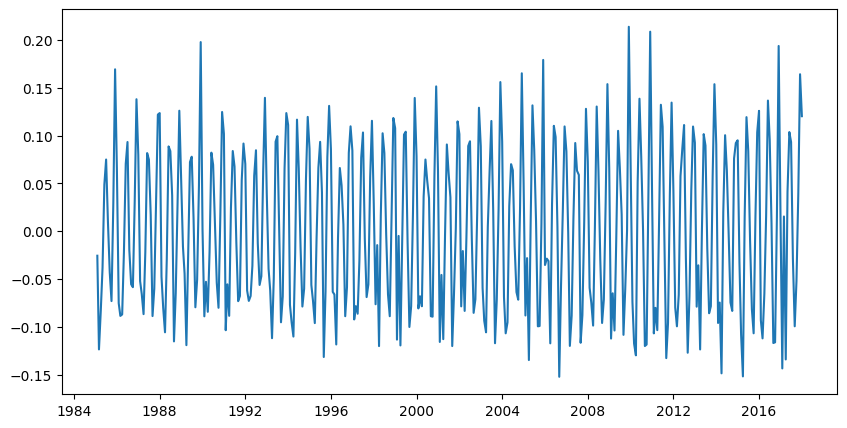

In [84]:
arimadf_log_diff.dropna(inplace=True)
plt.figure(figsize=(10,5))
plt.plot(arimadf_log_diff)

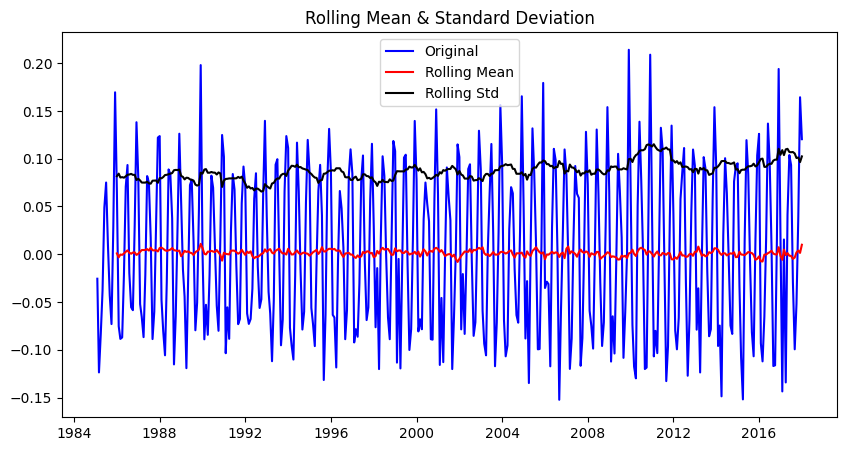

Results of Dickey Fuller Test:
Test Statistic                -6.748333e+00
p-value                        2.995161e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [85]:
test_stationarity(arimadf_log_diff)

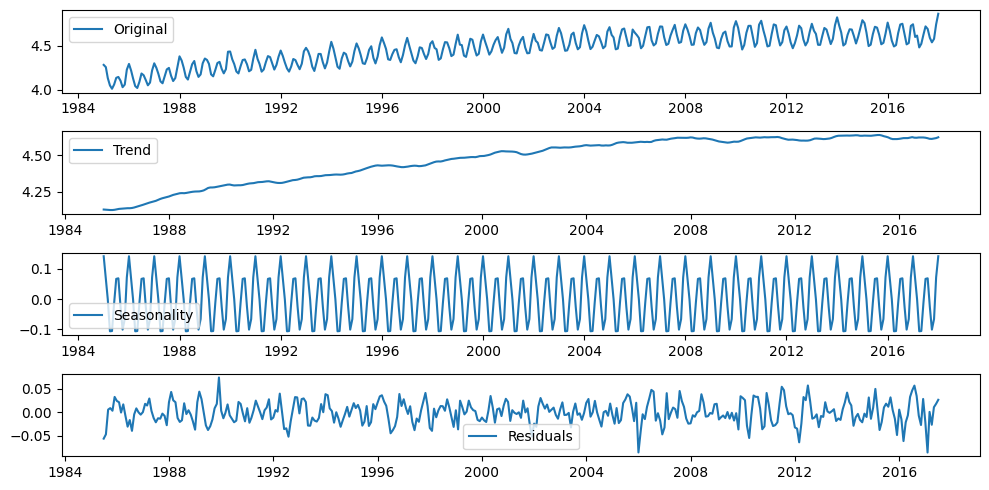

In [86]:
decomposition = seasonal_decompose(arimadf_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(arimadf_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [87]:
arimadf_decompose = residual
arimadf_decompose.dropna(inplace=True)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

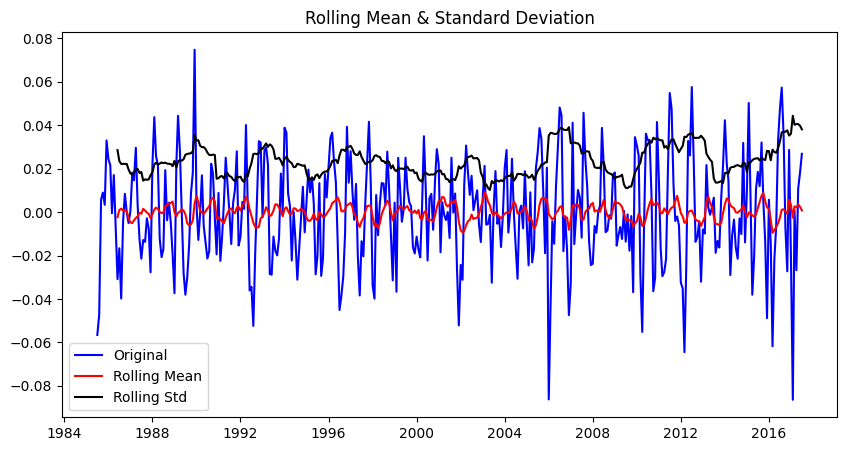

In [88]:
rollmean_decompose = arimadf_decompose.rolling(window=12).mean()
rollstd_decompose = arimadf_decompose.rolling(window=12).std()

plt.figure(figsize=(10,5))
plt.plot(arimadf_decompose, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [89]:
lag_acf = acf(arimadf_log_diff, nlags=20)
lag_pacf = pacf(arimadf_log_diff, nlags=20, method='ols')

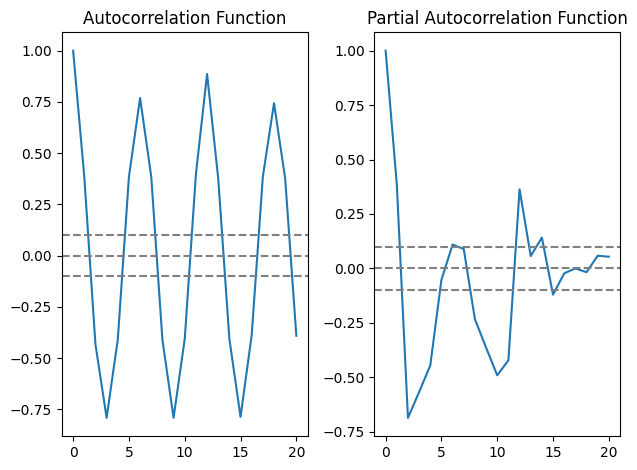

In [90]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(arimadf_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(arimadf_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(arimadf_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(arimadf_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

AR Model
(3,1,0)

Plotting AR model


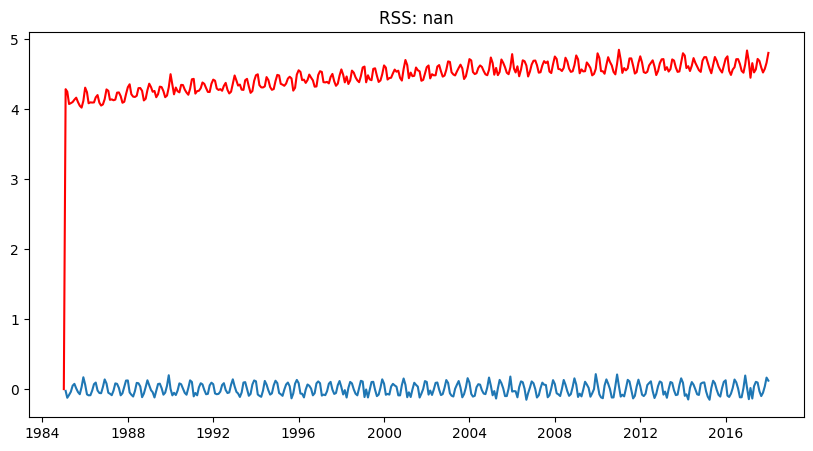

In [91]:
model1 = ARIMA(arimadf_log, order=(3,1,0))
results_AR = model1.fit()
plt.figure(figsize=(10,5))
plt.plot(arimadf_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues - arimadf_log_diff['Value'])**2))
print('Plotting AR model')

MA Model
(0,1,3)



Plotting MA model


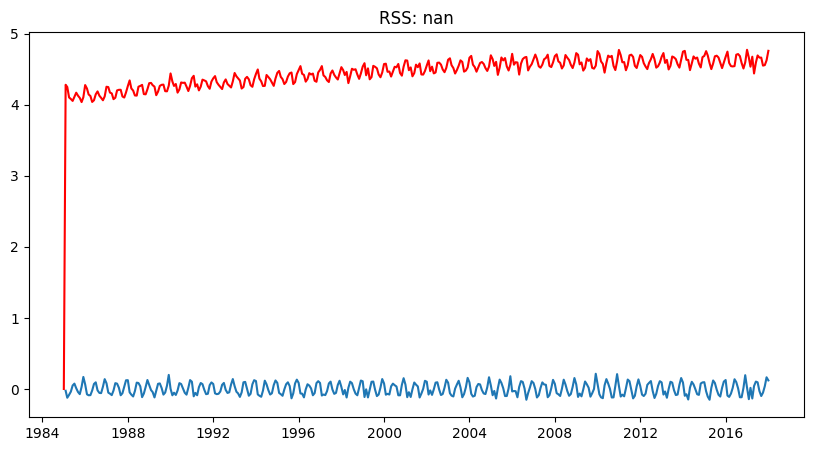

In [92]:
model2 = ARIMA(arimadf_log, order=(0,1,3))
plt.figure(figsize=(10,5))
results_MA = model2.fit()
plt.plot(arimadf_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - arimadf_log_diff['Value'])**2))
print('Plotting MA model')

AR+I+MA
(3,1,3)

Plotting ARIMA model


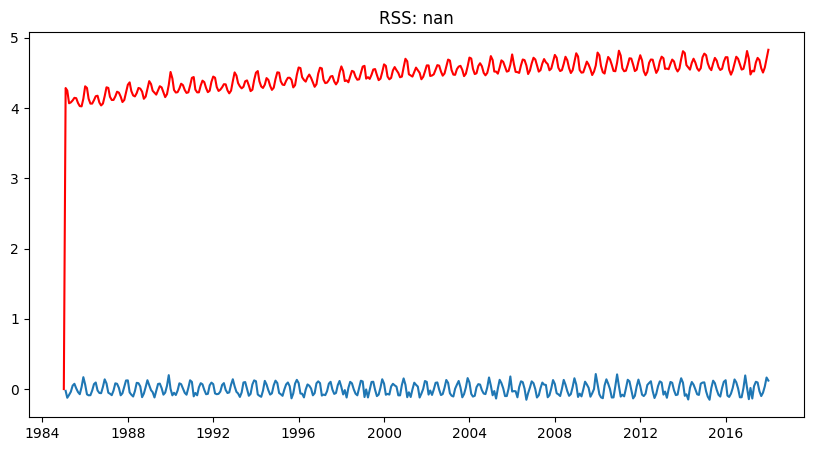

In [93]:
model = ARIMA(arimadf_log, order=(3,1,3))
plt.figure(figsize=(10,5))
results_ARIMA = model.fit()
plt.plot(arimadf_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - arimadf_log_diff['Value'])**2))
print('Plotting ARIMA model')

In [94]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

,0
DATE,
1985-01-01,0.000000
1985-02-01,4.283658
1985-03-01,4.247654
1985-04-01,4.066964
1985-05-01,4.079499


In [95]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

,0
DATE,
1985-01-01,0.000000
1985-02-01,4.283658
1985-03-01,8.531312
1985-04-01,12.598276
1985-05-01,16.677775


In [96]:
predictions_ARIMA_log = pd.Series(arimadf_log['Value'].iloc[0], index=arimadf_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

,0
DATE,
1985-01-01,4.283658
1985-02-01,8.567317
1985-03-01,12.814970
1985-04-01,16.881935
1985-05-01,20.961434


In [97]:
arimadf_log.head()

,Value
DATE,
1985-01-01,4.283658
1985-02-01,4.258049
1985-03-01,4.134369
1985-04-01,4.051287
1985-05-01,4.013046


In [98]:
arimadf_log.shape

(397, 1)

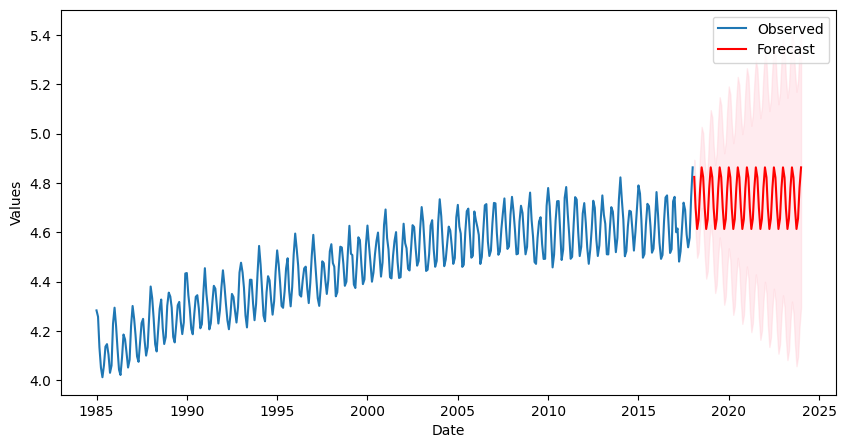

In [99]:
forecast_months = 72

last_date = arimadf_log.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

forecast = results_ARIMA.get_forecast(steps=forecast_months)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(arimadf_log, label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [100]:
# Grid search for best ARIMA parameters
p = range(0, 4)  # Typically values 0 to 3
d = range(0, 2)  # Differencing order, often 0 or 1
q = range(0, 4)  # Moving average order, usually small
pdq = list(itertools.product(p, d, q))
best_aic = float("inf")
best_params = None

In [101]:
for param in pdq:
    try:
        model = ARIMA(arimadf_log, order=param)
        results = model.fit()
        print(f"ARIMA{param} - AIC: {results.aic}")
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except Exception as e:
        print(f"ARIMA{param} - Error: {e}")
        continue

print(f"Best ARIMA parameters: {best_params} with AIC: {best_aic}")

ARIMA(0, 0, 0) - AIC: -234.23678073975486
ARIMA(0, 0, 1) - AIC: -653.121048919791
ARIMA(0, 0, 2) - AIC: -894.0500464681464
ARIMA(0, 0, 3) - AIC: -1001.0653643600349
ARIMA(0, 1, 0) - AIC: -834.3738289752259
ARIMA(0, 1, 1) - AIC: -971.6190519790281
ARIMA(0, 1, 2) - AIC: -1047.240861506345
ARIMA(0, 1, 3) - AIC: -1129.1174320159726
ARIMA(1, 0, 0) - AIC: -851.6466949276477
ARIMA(1, 0, 1) - AIC: -1004.9815943359986
ARIMA(1, 0, 2) - AIC: -1043.3700754530582
ARIMA(1, 0, 3) - AIC: -1125.3005549775776
ARIMA(1, 1, 0) - AIC: -895.9695563364198
ARIMA(1, 1, 1) - AIC: -970.9278886886558
ARIMA(1, 1, 2) - AIC: -1085.9214397331234
ARIMA(1, 1, 3) - AIC: -1130.093702570055
ARIMA(2, 0, 0) - AIC: -945.9407804179993
ARIMA(2, 0, 1) - AIC: -1014.3104120008197
ARIMA(2, 0, 2) - AIC: -1078.2966937223314
ARIMA(2, 0, 3) - AIC: -1117.329312429766
ARIMA(2, 1, 0) - AIC: -1143.3790174851702
ARIMA(2, 1, 1) - AIC: -1341.7704439994416
ARIMA(2, 1, 2) - AIC: -1499.606034355689
ARIMA(2, 1, 3) - AIC: -1486.046395162928
ARIMA(

In [102]:
# Fit the best ARIMA model
best_model = ARIMA(arimadf_log, order=best_params)
best_results = best_model.fit()

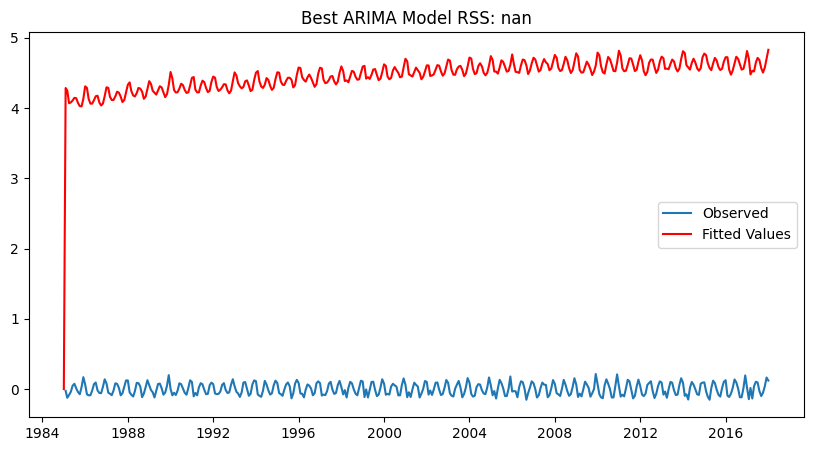

In [103]:
# Plot fitted values with observed data
plt.figure(figsize=(10,5))
plt.plot(arimadf_log_diff, label='Observed')
plt.plot(best_results.fittedvalues, color='red', label='Fitted Values')
plt.title(f'Best ARIMA Model RSS: {sum((best_results.fittedvalues - arimadf_log_diff["Value"])**2):.4f}')
plt.legend()
plt.show()

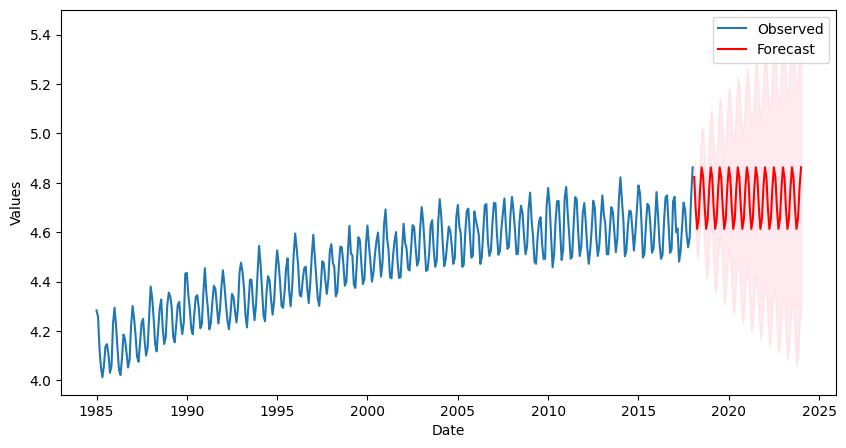

In [104]:
# Forecasting
forecast_months = 72
forecast = best_results.get_forecast(steps=forecast_months)
forecast_ci = forecast.conf_int()

# Index for future dates
last_date = arimadf_log.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

plt.figure(figsize=(10, 5))
plt.plot(arimadf_log, label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()